<a href="https://colab.research.google.com/github/ds24449/tf2_gan/blob/main/GAN_and_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

##Here I am going to use TensorFlow to implement DCGAN and WGAN
GAN is basically a game between Generator and Dicriminator. Generator has to Maximize the Loss and Discriminator has to minimize this loss.

I am going to Use MNIST digit dataset.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

In [1]:
#Lets Import our good friend TensorFlow
import numpy as np
import matplotlib.pyplot as plt
import time
import PIL
import imageio #for I/O ops on image data [to generate gifs!!]
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [3]:
(X_train,Y_train),(_,_) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1).astype('float32') ##Adding a channels dimension
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1).astype('float32')
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
# print('X_test:  '  + str(X_test.shape))
# print('Y_test:  '  + str(Y_test.shape))
X_train = X_train/255.

11493376/11490434 [==============================] - 0s 0us/step
MNIST Dataset Shape:
X_train: (60000, 28, 28, 1)
Y_train: (60000,)


##Remember Here
Do study more about what are BatchDatset objects and how to access whats inside them(is there a way without iterators?)

In [4]:
#Batch and Shuffle Data
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(X_train.shape[0]).batch(BATCH_SIZE)
print(type(train_dataset))
print(train_dataset.__len__)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<bound method DatasetV2.__len__ of <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>>


#Create Models 
Both Generator and Discriminator are built using Keras API

##Generator Model :- 
Generator is a Upsampler which takes a Noise vector and produces a sensible(to us) image.

We use a Dense Layer to Take input noise vector and thne upsample it to a size of [28,28,1] i.e to the size of an image in MNIST Dataset

In [5]:
def get_generator_model():
  """Returns A Genreator Model 
  
    Upsample Images from vector to a tensor of shape (28,28,1)
  """
  model = Sequential([
      layers.Dense(7*7*256,use_bias=False,input_shape=(100,)),
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      layers.Reshape(target_shape=(7,7,256)),

      #real upsampling starts here
      layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",use_bias=False),
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False),
      layers.BatchNormalization(),
      layers.LeakyReLU(),
      layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding="same", activation='tanh', use_bias=False),
  ])
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

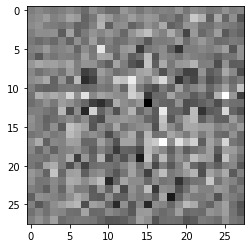

In [6]:
gen = get_generator_model()
gen.summary()
noise = tf.random.normal([1,100])

generated_image = gen(noise,training = False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

##The Discriminator
It is a CNN based Classification model
Classifies between Real and Fake

In [7]:
def get_discriminator_model():
  """ Discrimiator
  If no activation is defined at Dense layer then Negative value for fakes 
  and positive for Real
  """
  model = Sequential([
      layers.Conv2D(64,(5,5),padding = "valid",input_shape=[28,28,1]),
      layers.LeakyReLU(),
      layers.Dropout(0.45),
      layers.Conv2D(128,(5,5),padding = "valid",input_shape=[28,28,1]),
      layers.LeakyReLU(),
      layers.Dropout(0.45),
      layers.Flatten(),
      layers.Dense(1),
  ])
  return model

In [8]:
disc = get_discriminator_model()
disc.summary()
print("------------------------")
print(disc(generated_image))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)            

###Base Loss Function for Disc and Gen


In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
##Optimizer is the same all mighty Adam Optimizer
gen_opt = tf.keras.optimizers.Adam()
disc_opt = tf.keras.optimizers.Adam()

###Discriminator Loss
this loss is combined loss of discriminators performance on Real images and on fake images

In [30]:
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  return real_loss+fake_loss


###Gen Loss
how well the generator is able to fool the discriminator

In [31]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [32]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

###Defining Training Loop

In [33]:
EPOCHS = 3
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

### The Decorator @tf.function
is used create a graph from defined function
https://www.tensorflow.org/guide/intro_to_graphs#tracing_graphs

In [38]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    fake_image = gen(noise,training=True)

    real_output = disc(images,training=True)
    fake_output = disc(fake_image,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)
  #Now we calculate the loss using GradientTapes
  gradients_of_generator = gen_tape.gradient(gen_loss,gen.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,disc.trainable_variables)
  #Optimize the variables with grads
  gen_opt.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
  disc_opt.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))




In [39]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    generate_and_print(gen,noise,epochs+1)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Generate and print images

In [46]:
def generate_and_print(model, test_input, epoch):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

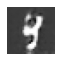

Time for epoch 1 is 40.169257164001465 sec


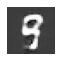

Time for epoch 2 is 40.19777989387512 sec


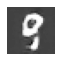

Time for epoch 3 is 40.43869209289551 sec


In [47]:
train(train_dataset,EPOCHS)